In [1]:
%load_ext autoreload
%autoreload 2

import sys
import copy
import math
import pickle

sys.path.append("../../")

import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import meshio

import implicitmodules.torch as dm

torch.set_default_tensor_type(torch.FloatTensor)

dm.Utilities.set_compute_backend('torch')

In [2]:
dim = 3

In [3]:
r_rmin = 0.5
r_rmax = 5.
n_rowrigid = 5
r_rigid = torch.linspace(r_rmin, r_rmax, n_rowrigid)
r_gmin = 5.8
r_gmax = 6.5
n_rowgrowth = 2
r_growth = torch.linspace(r_gmin, r_gmax, n_rowgrowth)

npts_row = 20
theta = torch.linspace(0., 2 * math.pi, npts_row + 1)[:-1]

pts_rigid = torch.cat([ torch.tensor([[r * math.cos(th), r * math.sin(th)] for th in theta]) for r in r_rigid])
pts_growth = torch.cat([ torch.tensor([[r * math.cos(th), r * math.sin(th)] for th in theta]) for r in r_growth])

(-7.15, 7.15, -7.15, 7.15)

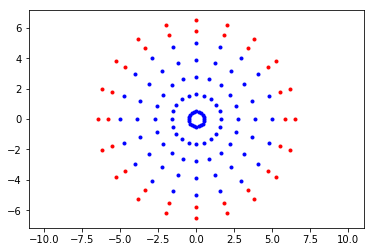

In [4]:
plt.figure()
plt.plot(pts_rigid[:,0], pts_rigid[:,1], '.b')
plt.plot(pts_growth[:,0], pts_growth[:,1], '.r')
plt.axis('equal')

In [34]:
N_rigid = pts_rigid.shape[0]
N_growth = pts_growth.shape[0]
eps = 0.5
pts_implicit1_m = torch.cat([torch.cat([pts_rigid, pts_growth]).clone(), torch.zeros([N_rigid + N_growth, 1])], dim = 1)
pts_implicit1_t = torch.cat([torch.cat([pts_rigid, pts_growth]).clone(), eps + torch.zeros([N_rigid + N_growth, 1])], dim = 1)
pts_implicit1_d = torch.cat([torch.cat([pts_rigid, pts_growth]).clone(), -eps + torch.zeros([N_rigid + N_growth, 1])], dim = 1)
pts_implicit1_m.shape

torch.Size([140, 3])

In [35]:
pts_implicit1 = torch.cat([pts_implicit1_t, pts_implicit1_m, pts_implicit1_d])
print(pts_implicit1.shape)

torch.Size([420, 3])


In [19]:
C = torch.zeros(pts_implicit1.shape[0], dim, 1)
C[N_rigid:, 2, 0] = 1.
C[]
import copy
import math

In [20]:
R_2D_init = torch.stack([dm.Utilities.rot2d(a) for a in theta])
R = torch.cat([torch.stack([torch.cat([torch.cat([r.clone(), torch.zeros([2,1])], dim = 1), torch.tensor([[0., 0., 1.]])], dim=0) for r in R_2D_init]) for i in range(n_rowrigid + n_rowgrowth)])
#R = torch.stack(R)

In [21]:
R[5]

tensor([[-4.3711e-08, -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00, -4.3711e-08,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [22]:
R_2D_init[5]

tensor([[-4.3711e-08, -1.0000e+00],
        [ 1.0000e+00, -4.3711e-08]])

In [23]:
print(pts_implicit1.shape)
print(C.shape)
print(R.shape)

torch.Size([140, 3])
torch.Size([140, 3, 1])
torch.Size([140, 3, 3])


In [24]:
#pllt the projection on 2D plane
#%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], 'xk')
plt.plot(pts_implicit1[:N_rigid,0], pts_implicit1[:N_rigid,1], 'ok')
dm.Utilities.plot_C_ellipse(ax_left, pts_implicit1[:,:2], C[:,:2,:], R[:,:2,:2], c_index=0, scale=0.5, color='red')
plt.axis('equal')

(-7.15, 7.15, -7.15, 7.15)

In [25]:
sigma1 = 5.
implicit1 = dm.DeformationModules.ImplicitModule1.build_and_fill(dim, pts_implicit1.shape[0], C, sigma1, 0.001, gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()))

In [26]:
cotan = torch.zeros_like(pts_implicit1)
mm = 5000.
cotan[N_rigid + 1, 1:] = mm
cotan[N_rigid + 19, 1:] = -mm
cotan[N_rigid + 21, 1:] = mm
cotan[-1, 1:] = -mm


cotan[N_rigid + 9, 1:] = mm
cotan[N_rigid + 11, 1:] = -mm
cotan[N_rigid + 29, 1:] = mm
cotan[N_rigid + 31, 1:] = -mm

cotan[N_rigid + 4, 0] = mm
cotan[N_rigid + 6, 0] = -mm
cotan[N_rigid + 24, 0] = mm
cotan[N_rigid + 26, 0] = -mm

cotan[N_rigid + 14, 0] = -mm
cotan[N_rigid + 16, 0] = mm
cotan[N_rigid + 34, 0] = -mm
cotan[N_rigid + 36, 0] = mm


implicit1.manifold.fill_cotan([cotan.view(-1).requires_grad_(), torch.zeros_like(R).requires_grad_()])

In [27]:
#plot the projection on 2D plane
#%matplotlib inline
ax_left = plt.subplot(1, 1, 1)
plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
#plt.plot(pts_implicit1[:N_rigid,0], pts_implicit1[:N_rigid,1], 'ok')
plt.quiver(pts_implicit1[:,0], pts_implicit1[:,1], cotan[:,0], cotan[:,1])
#dm.Utilities.plot_C_ellipse(ax_left, pts_implicit1[:,:2], C[:,:2,:], R[:,:2,:2], c_index=0, scale=0.5, color='red')
plt.axis('equal')

(-7.15, 7.15, -7.15, 7.15)

In [28]:
dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([implicit1]), 10, 'euler')
pts = implicit1.manifold.gd[0].detach().view(-1, dim)

In [29]:
#plot the projection on 2D plane
#%matplotlib inline
ax_left = plt.subplot(1, 1, 1)
plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
#plt.plot(pts_implicit1[:N_rigid,0], pts_implicit1[:N_rigid,1], 'ok')
#plt.quiver(pts_implicit1[:,0], pts_implicit1[:,1], cotan[:,0], cotan[:,1])
plt.plot(pts[:,0], pts[:,1], 'xr')
#dm.Utilities.plot_C_ellipse(ax_left, pts_implicit1[:,:2], C[:,:2,:], R[:,:2,:2], c_index=0, scale=0.5, color='red')
plt.axis('equal')

(-7.15, 7.15, -7.15, 7.15)

In [30]:
pts

tensor([[ 5.0000e-01,  0.0000e+00,  0.0000e+00],
        [ 4.7553e-01,  1.5451e-01,  0.0000e+00],
        [ 4.0451e-01,  2.9389e-01,  0.0000e+00],
        [ 2.9389e-01,  4.0451e-01,  0.0000e+00],
        [ 1.5451e-01,  4.7553e-01,  0.0000e+00],
        [-2.1856e-08,  5.0000e-01,  0.0000e+00],
        [-1.5451e-01,  4.7553e-01,  0.0000e+00],
        [-2.9389e-01,  4.0451e-01,  0.0000e+00],
        [-4.0451e-01,  2.9389e-01,  0.0000e+00],
        [-4.7553e-01,  1.5451e-01,  0.0000e+00],
        [-5.0000e-01, -4.3711e-08,  0.0000e+00],
        [-4.7553e-01, -1.5451e-01,  0.0000e+00],
        [-4.0451e-01, -2.9389e-01,  0.0000e+00],
        [-2.9389e-01, -4.0451e-01,  0.0000e+00],
        [-1.5451e-01, -4.7553e-01,  0.0000e+00],
        [ 5.9624e-09, -5.0000e-01,  0.0000e+00],
        [ 1.5451e-01, -4.7553e-01,  0.0000e+00],
        [ 2.9389e-01, -4.0451e-01,  0.0000e+00],
        [ 4.0451e-01, -2.9389e-01,  0.0000e+00],
        [ 4.7553e-01, -1.5451e-01,  0.0000e+00],
        [ 1.6250e+00

In [33]:
# plot 3D
%matplotlib qt5
fig = plt.figure()

ax = fig.add_subplot(121, projection='3d')
ax.scatter(pts_implicit1[:, 0].numpy(), pts_implicit1[:, 1].numpy(), pts_implicit1[:, 2].numpy(), marker='.')
ax.scatter(pts[:, 0].numpy(), pts[:, 1].numpy(), pts[:, 2].numpy(), marker='x', color='r')
set_aspect_equal_3d(ax)

In [32]:
def set_aspect_equal_3d(ax):
    """Fix equal aspect bug for 3D plots."""

    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()

    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)

    plot_radius = max([abs(lim - mean_)
                       for lims, mean_ in ((xlim, xmean),
                                           (ylim, ymean),
                                           (zlim, zmean))
                       for lim in lims])

    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])

In [235]:
#implicit1.compute_geodesic_control(implicit1.manifold)
v = implicit1(implicit1.manifold.gd[0].view(-1, dim)).detach()
print(implicit1.controls)

tensor([-2.7234], grad_fn=<AsStridedBackward>)


In [237]:
v

tensor([[ 2.1143e-01, -2.6703e-05,  0.0000e+00],
        [ 2.0107e-01,  6.5336e-02,  0.0000e+00],
        [ 1.7101e-01,  1.2430e-01,  0.0000e+00],
        [ 1.2419e-01,  1.7110e-01,  0.0000e+00],
        [ 6.5218e-02,  2.0113e-01,  0.0000e+00],
        [-1.4585e-04,  2.1149e-01,  0.0000e+00],
        [-6.5499e-02,  2.0114e-01,  0.0000e+00],
        [-1.2445e-01,  1.7110e-01,  0.0000e+00],
        [-1.7123e-01,  1.2431e-01,  0.0000e+00],
        [-2.0126e-01,  6.5357e-02,  0.0000e+00],
        [-2.1160e-01,  4.2915e-06,  0.0000e+00],
        [-2.0124e-01, -6.5352e-02,  0.0000e+00],
        [-1.7120e-01, -1.2431e-01,  0.0000e+00],
        [-1.2441e-01, -1.7112e-01,  0.0000e+00],
        [-6.5443e-02, -2.0117e-01,  0.0000e+00],
        [-8.8215e-05, -2.1153e-01,  0.0000e+00],
        [ 6.5272e-02, -2.0119e-01,  0.0000e+00],
        [ 1.2424e-01, -1.7114e-01,  0.0000e+00],
        [ 1.7104e-01, -1.2435e-01,  0.0000e+00],
        [ 2.0108e-01, -6.5389e-02,  0.0000e+00],
        [ 5.7570e-01

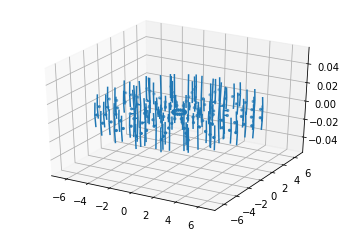

In [236]:
%matplotlib qt5
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(pts_implicit1[:, 0].numpy(), pts_implicit1[:, 1].numpy(), pts_implicit1[:, 2].numpy(), marker='.')
ax.quiver(pts_implicit1[:, 0].numpy(), pts_implicit1[:, 1].numpy(), pts_implicit1[:, 2].numpy(), v[:, 0].numpy(), v[:, 1].numpy(), v[:, 2].numpy(), length=0.1, normalize=False)

In [85]:
pts.shape

torch.Size([210, 2])